# Fit bambi model to males and females combined

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
)
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
c = PlotConfig()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_mouse_area_df_v00.parquet'
    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [6]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

df['sex'] = np.where(sex_id == 1)[0]
df = df.set_index('sex', append=True)

In [7]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

age_sd = 0.045

hypparams = {
    "log_age": True,
    "min_age": 1,
    "max_age": 130,
    "age_sd": age_sd,  # weeks
    "n_age_samples": 1500,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 175,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 250,
}

## Load epigenetic data and map to behavioral recordings

In [8]:
from itertools import product

In [9]:
df_epi = pd.read_parquet('/n/groups/datta/David/behavior/longtogeny/processed/df_meta_with_epi_age_prediction_72_samples.parquet')

In [10]:
# create map

mapping = {}
for i, (age, cage, mouse_num) in enumerate(
    product([4, 8, 12, 52, 78, 90], range(1, 5), range(1, 5)), start=1
):
    mapping[i] = f"{age}M_{cage:02d}_{mouse_num:02d}"

In [11]:
df_epi['mouse_id'] = df_epi['sample_id'].map(mapping)

# NaNs are from the 24, 36 wk old animals
df_epi = df_epi.dropna(subset=['mouse_id'])

## Get males vs females

In [12]:
mdl = fit_model(features, hypparams, 5)

In [13]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [19]:
age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=np.argmax(features['mice'], axis=0)),
)

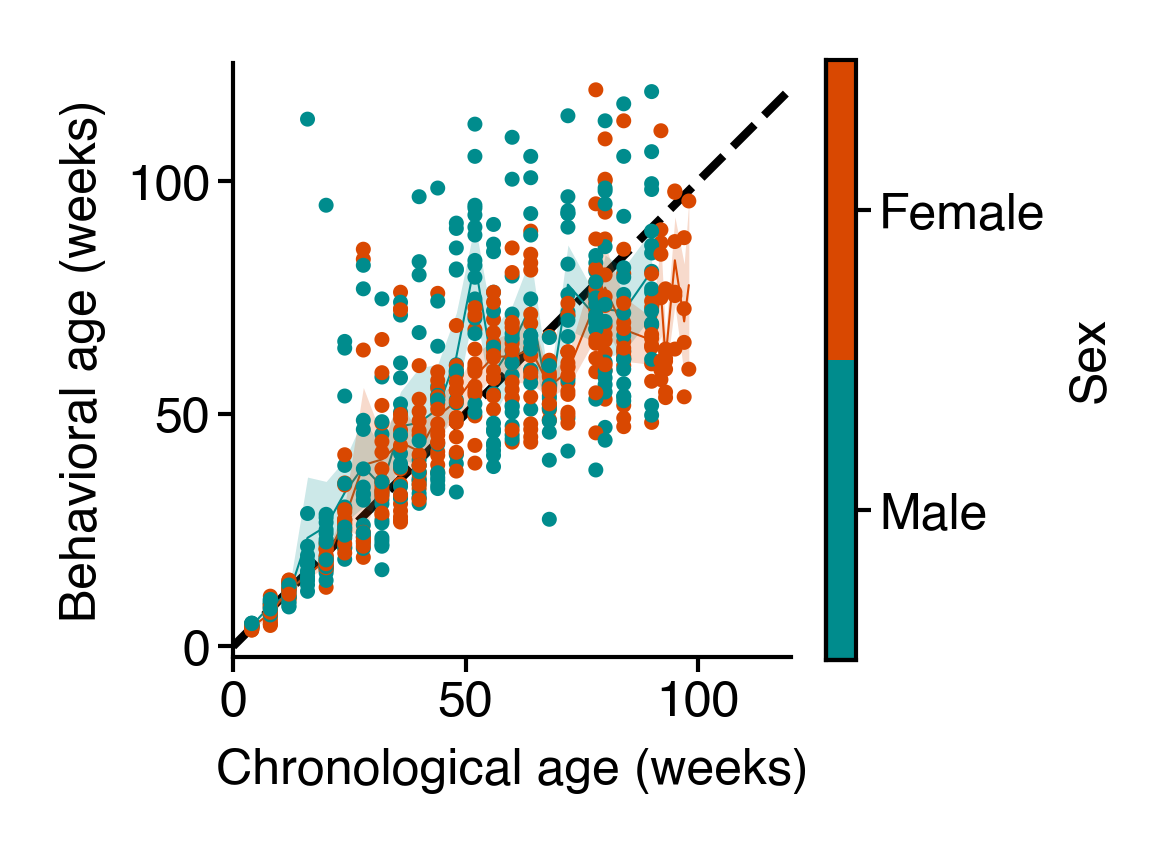

In [20]:
fig = make_plot(age_df, 1.5, 1.3)

## Sorting by model predictions

In [21]:
df_copy = df.copy().astype('float32')

# normalize to sum to 1
df_copy = df_copy / (df_copy.sum(1).to_numpy()[:, None])
df_copy['beh_age'] = mdl['bio_ages']
df_copy = df_copy.set_index('beh_age', append=True)

[[], []]

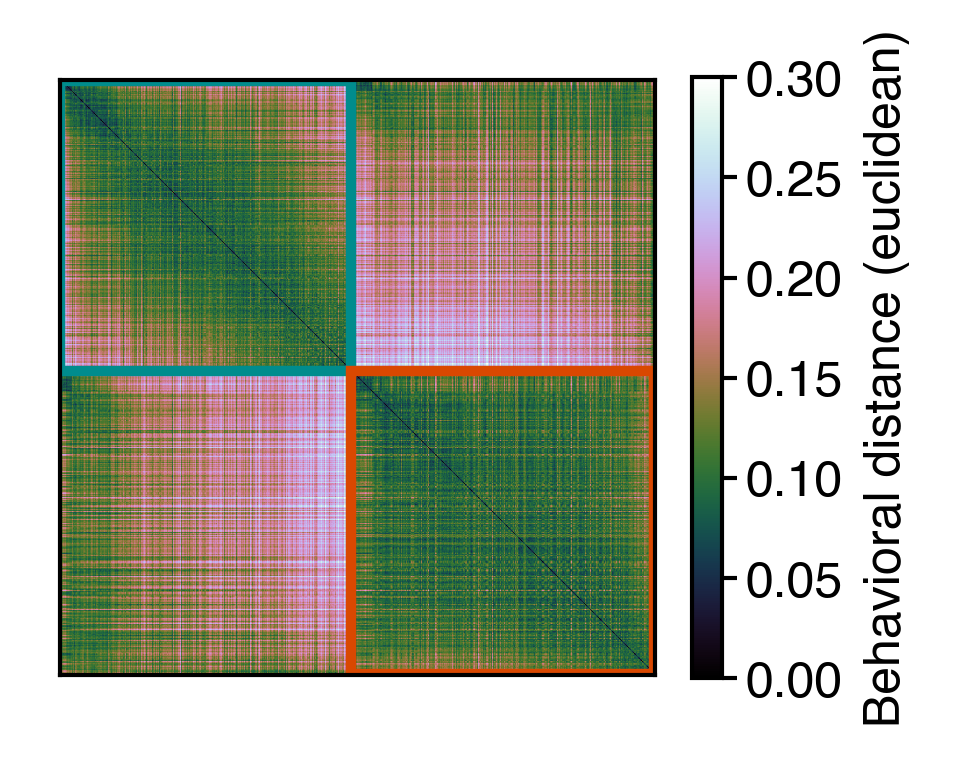

In [22]:
d = pdist(df_copy.sort_index(level=["sex", "beh_age"]), metric="euclidean")
d = squareform(d)

fig = figure(1.6, 1.3)
ax = fig.gca()
im = ax.imshow(d, cmap="cubehelix", vmax=0.3)
fig.colorbar(im, ax=ax, label="Behavioral distance (euclidean)")

start = len(df) - len(female_df) - 1
patch = plt.Rectangle(
    (0, 0),
    start,
    start,
    edgecolor=COLORMAPS.ont_male(255),
    facecolor="none",
    linewidth=1.25,
)
ax.add_patch(patch)
patch = plt.Rectangle(
    (start, start),
    len(female_df) - 1,
    len(female_df) - 1,
    edgecolor=COLORMAPS.ont_female(255),
    facecolor="none",
    linewidth=1.25,
)
ax.add_patch(patch)
ax.set(xticks=[], yticks=[])

## PCA on model predictions

In [23]:
from sklearn.decomposition import PCA

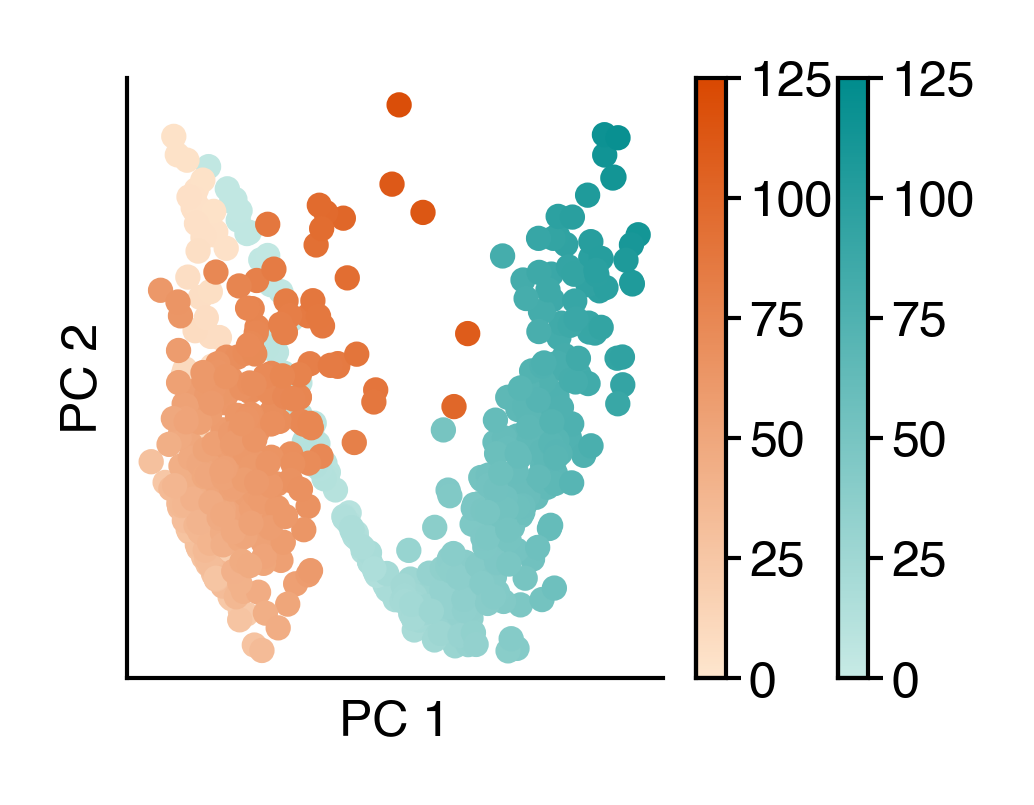

In [24]:
pc = mdl['predicted_counts']
pc = pc / pc.sum(1, keepdims=True)

pca = PCA(n_components=2)
scores = pca.fit_transform(pc)
scores_df = pd.DataFrame(scores, index=df.index)


scores_df['bio_age'] = mdl['bio_ages']

fig = figure(1.8, 1.3)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df['bio_age'], cmap=cm, s=5, vmin=0, vmax=125)
    cb = fig.colorbar(im, ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()

In [28]:
males_all = df_copy.loc[pd.IndexSlice[:, :, :, :, :, :, 0], :]

In [32]:
males_all.to_parquet('/n/groups/datta/win/longtogeny/data/epigenetics/2024-05-29_all_male_ontogeny_mice_with_beh_age.parquet')

In [29]:
males_epi = males_all[males_all.index.get_level_values('mouse').isin(df_epi['mouse_id'])]

In [33]:
males_epi.to_parquet('/n/groups/datta/win/longtogeny/data/epigenetics/2024-05-29_epi_only_male_ontogeny_mice_with_beh_age.parquet')

In [30]:
males_epi

syllables                                                                                                              0   \
age mouse     subject_name session_name uuid                                 date                sex beh_age                
4   4M_01_01  4M_01_01     otgy_4M_01   7f63f2a3-29b6-400d-bec1-33b9549004cb 2023-12-01 10:54:30 0   4.942997    0.002006   
    4M_01_03  4M_01_03     otgy_4M_01   c7b0fe38-3cfb-43e3-9eb8-e3db19df6920 2023-12-01 11:04:03 0   4.202199    0.004662   
    4M_01_04  4M_01_04     otgy_4M_01   65f7626b-ac07-4d1e-93b9-2b0320cb740b 2023-12-01 07:51:47 0   3.993509    0.003431   
    4M_02_03  4M_02_03     otgy_4M_02   45d3743e-96c2-4e6c-befb-84e48d186f0e 2023-12-01 12:54:38 0   4.478464    0.006810   
    4M_02_04  4M_02_04     otgy_4M_02   9c1f8569-041a-4d59-b36f-f021c6e45843 2023-12-01 09:55:01 0   4.990434    0.008181   
    4M_03_01  4M_03_01     otgy_4M_03   e638644c-816a-4d8b-921d-df38c9efbf2e 2023-12-01 14:43:51 0   4.507071    0.003121   
    4M_04_04  4M_04_04     otgy_4M_04   845ab350-d6fe-498a-8cf4-311818f3bb40 2023-12-01 13:09:03 0   4.044690    0.005018   
8   8M_01_01  8M_01_01     otgy_8M_01   0c69468a-c141-407b-9a59-280f083d8218 2023-12-02 10:57:04 0   9.050835    0.003876   
    8M_02_04  8M_02_04     otgy_8M_02   b97fc2f7-bef3-4af3-8e9d-72acb6617ca7 2023-12-02 10:10:14 0   8.546760    0.006102   
    8M_03_01  8M_03_01     otgy_8M_03   3c3559e5-367b-4e84-9eed-005755b72297 2023-12-02 15:11:12 0   7.083154    0.011103   
    8M_03_02  8M_03_02     otgy_8M_03   cbc02672-48de-4837-8292-afe856efe77a 2023-12-02 12:11:35 0   9.738430    0.005013   
    8M_03_03  8M_03_03     otgy_8M_03   7502262a-8488-4e26-9cb7-1126b7813437 2023-12-02 15:12:05 0   6.752854    0.006281   
    8M_03_04  8M_03_04     otgy_8M_03   fc1ad281-ba06-41d2-872b-2dae6b26661a 2023-12-02 12:12:25 0   8.019530    0.005664   
    8M_04_03  8M_04_03     otgy_8M_04   35e19ab9-10cb-4b14-a5f8-37909539ea64 2023-12-02 17:15:53 0   9.800634    0.002460   
    8M_04_04  8M_04_04     otgy_8M_04   a64186e5-c695-4bdb-9e9b-8cb3d1393de4 2023-12-02 14:16:17 0   9.022066    0.007285   
12  12M_01_04 12M_01_04    otgy_12M_01  cf5da8e0-712f-46da-b35b-6956338a608a 2023-12-02 09:29:02 0   10.612550   0.009031   
    12M_02_01 12M_02_01    otgy_12M_02  c5fd161f-6690-42d3-b481-ad725de46306 2023-12-02 14:30:46 0   11.025827   0.003681   
    12M_02_02 12M_02_02    otgy_12M_02  79323dea-4c67-4a6c-91cd-598f93205637 2023-12-02 11:31:09 0   13.474617   0.006548   
    12M_03_01 12M_03_01    otgy_12M_03  ae668e1f-2399-42e6-9ff6-0a359890bdcb 2023-12-02 16:33:34 0   8.656293    0.001798   
    12M_03_03 12M_03_03    otgy_12M_03  5db7e454-fd28-4a05-88c0-dc46a9722e80 2023-12-02 16:34:17 0   12.764736   0.005074   
    12M_04_01 12M_04_01    otgy_12M_04  115ec7be-9617-473c-802d-a41fc4a57f29 2023-12-02 18:34:44 0   11.901292   0.003858   
    12M_04_03 12M_04_03    otgy_12M_04  20fb06ee-752b-4e52-b78a-c4111282a57d 2023-12-02 18:35:24 0   13.177649   0.008850   
52  52M_01_01 52M_01_01    otgy_52M_01  1840eb80-afa7-433e-b89b-534a49ce87a2 2023-12-02 11:48:03 0   74.708000   0.003147   
    52M_01_04 52M_01_04    otgy_52M_01  ddc649b3-007f-48ff-8afd-72387c853b25 2023-12-02 08:50:02 0   94.855782   0.001382   
    52M_02_01 52M_02_01    otgy_52M_02  c317508c-a488-4ccf-b3f4-a15aafd36770 2023-12-02 13:50:56 0   79.366470   0.009633   
    52M_03_01 52M_03_01    otgy_52M_03  ac16b0cc-a30b-4a11-8c68-7dfdca84f266 2023-12-02 15:52:44 0   82.983871   0.011107   
    52M_03_04 52M_03_04    otgy_52M_03  a21278cf-9980-48ac-84b3-51ed3258379d 2023-12-02 12:53:43 0   92.765259   0.014657   
    52M_04_01 52M_04_01    otgy_52M_04  fe2c6fa9-1844-4ae8-beae-2630b257ada1 2023-12-02 17:55:33 0   81.933830   0.005131   
    52M_04_04 52M_04_04    otgy_52M_04  c194a603-52a8-4877-904a-ac2b1d1f7ba5 2023-12-02 14:56:47 0   50.341026   0.006519   
78  78M_01_01 78M_01_01    otgy_78M_01  c4fc65f4-728d-419a-a155-597687c1b87d 2023-12-04 10:30:45 0   73.528236   0.000809   
